# Случайные процессы. Прикладной поток.
## Практическое задание 4

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 4"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `4.N.ipynb` и `4.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* При проверке никакой код запускаться не будет.


--------------

Для выполнения задания потребуются следующие библиотеки: hmmlearn, librosa. Следующими командами можно их поставить (Ubuntu):

sudo pip3 install hmmlearn

sudo pip3 install librosa


--------------

### 1. Скрытые марковские модели (2 балла)

Реализация методов является полезной, но технически сложной, поэтому мы воспользуемся готовой реализацией `hmmlearn`. Документация http://hmmlearn.readthedocs.io/. Интерфейс данной библиотеки максимально близок к библиотеке `scikit-learn`. 

Все необходимые комментарии по интерфейсу библиотеки `hmmlearn` приведены в коде далее. Следуйте указаниям.

In [261]:
import numpy as np
import sys
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [156]:
# Если при использовании библиотеки будут появлятся различные warnings,
# раскомментируйте и выполните следующий код
import warnings
warnings.filterwarnings("ignore")

Зададим некоторую скрытую марковскую модель

In [22]:
# Объявление скрытой марковской модели с двумя скрытыми состояниями, 
# в которой предполагается, каждое состояние может генерировать 
# гауссовский случайный вектор с произвольной матрицей ковариаций.
# Используется метод Витерби.
# Поставьте 'map', чтобы использовать метод forward-backward.
model = hmm.GaussianHMM(n_components=2, covariance_type='full', 
                        algorithm='viterbi')

# Параметры марковской цепи - начальное состояние и матрица переходных вероятностей
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.07, 0.93]])

# Параметры условных распределений Y_j при условии X_j - вектора средних и
# матрица ковариаций по количеству состояний. Поскольку в данном случае
# распределения одномерные, ниже записаны два вектора размерности 1
# и две матрицы размерности 1x1
model.means_ = np.array([[0.0], [3.0]])
model.covars_ = np.array([[[1]], [[1]]])

Сгенерируем некоторую последовательность с помощью определенной выше модели.

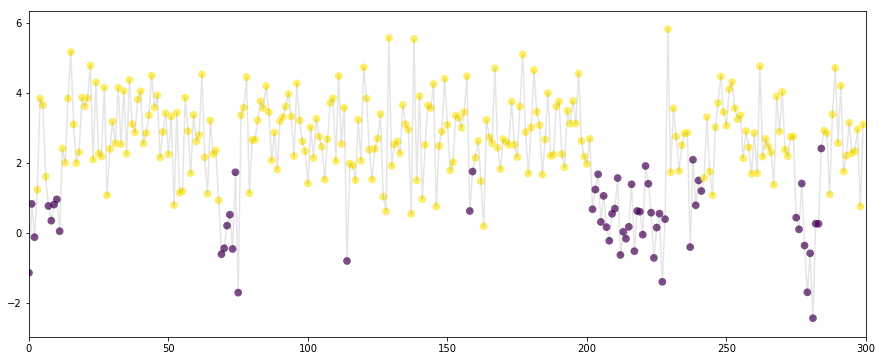

In [23]:
size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=np.array(X), lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.show()


На основе сгенерированной выше последовательности оценим параметры ("обучим") скрытой марковской модели и значения скрытых состояний.

In [24]:
# Объявление скрытой марковской модели, в которой при оценке параметров 
# будет производиться не более n_iter итераций EM-алгоритма.
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, algorithm='viterbi')

# Оценка параметров ("обучение")
remodel.fit(Y)  

# Оценка ("предсказание") значений скрытых состояний
X_predicted = remodel.predict(Y)

Теперь изобразим полученные результаты. На обоих графиках непрозразными маленькими кружочками отмечена исходная последовательность. Полупрозрачными большими кружочками отмечены оценки значений скрытых состояний. На первом графике отмечены все такие точки, на втором только те из них, оценка значения скрытого состояния получилась непрпавильно.

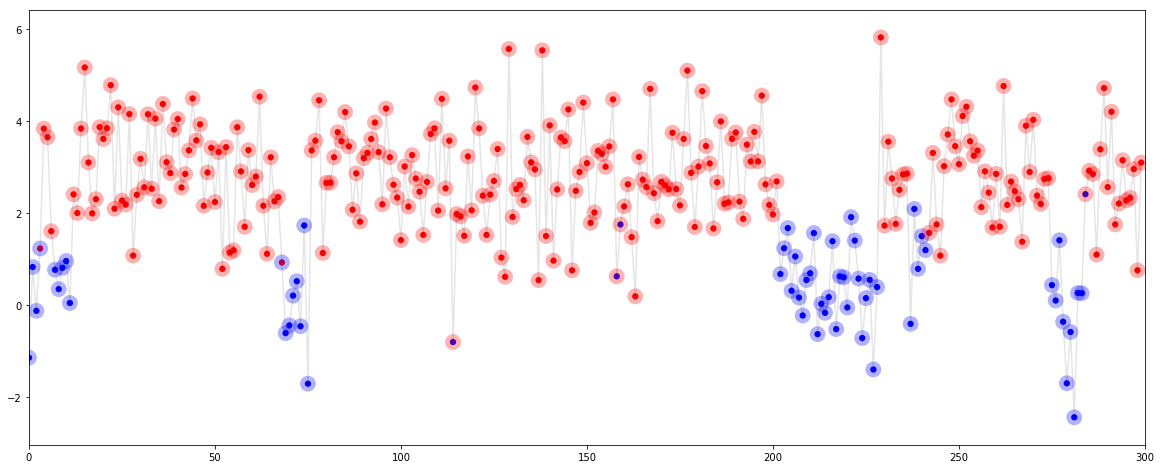

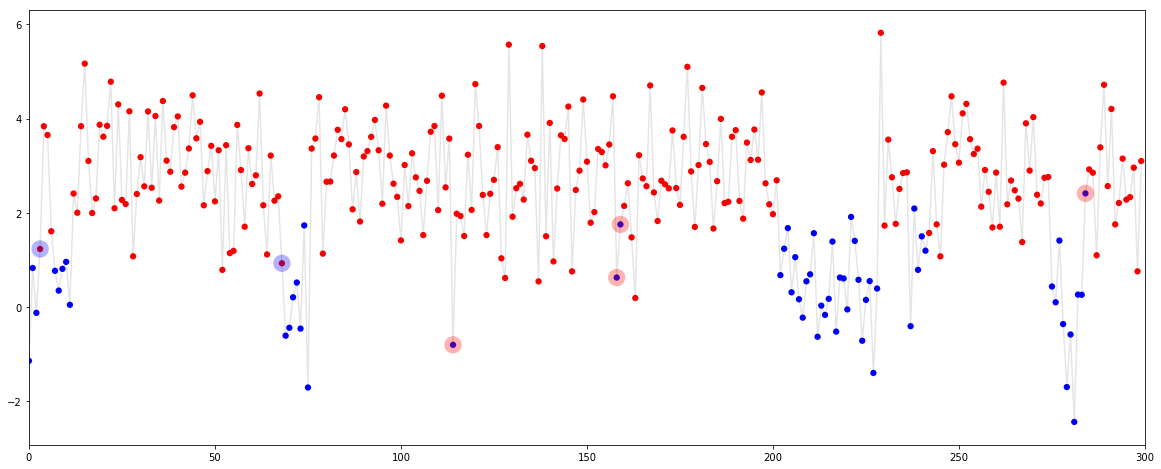

In [25]:
colors = np.array(['blue', 'red'])

# Состояния определяются с точностью до их перестановки.
# При необходимости меняем местами состояния
if (X != X_predicted).sum() > size / 2:
    X_predicted = 1 - X_predicted

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X_predicted)], 
            lw=0, s=250, alpha=0.3)
plt.xlim((0, size))
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted], Y[:, 0][X != X_predicted], 
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()

Как понять, что EM-алгоритм сошелся? Для этого нужно посчитать значение некоторого функционала (см. презентацию), который умеет считать библиотека `hmmlearn`, поэтому мы всего лишь посмотрим на его значения. Данная функциональность в библиотеке реализованна слишком странно. Следуйте комментариям.

In [26]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

Теперь можно загрузить значения и построить график

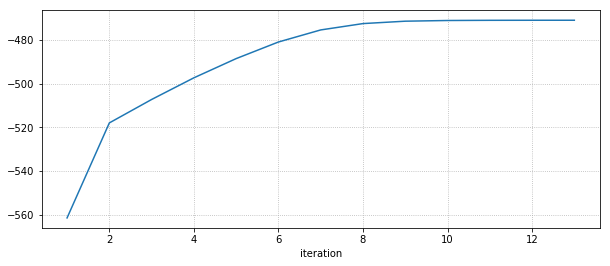

In [27]:
values = np.loadtxt('./est_values.txt')

plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.grid(ls=':')
plt.show()

Выполните те же операции для следующих двух случаев

* скрытая марковская цепь имеет три скрытых состояния;

* распределение $Y_j$ при условии $X_j$ является двумерным гауссовским.

 ## 1.

Задаем скрытую марковскую цепь с тремя скрытыми состояниями

In [93]:
model = hmm.GaussianHMM(n_components=3, covariance_type='full', 
                        algorithm='viterbi')

model.startprob_ = np.array([0.5, 0.3, 0.4])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.15, 0.8, 0.05],
                            [0.05, 0.03, 0.92]])

model.means_ = np.array([[0.0], [3.0], [5.0]])
model.covars_ = np.array([[[1]], [[1]], [[1]]])

Генерируем последовательности X и Y.

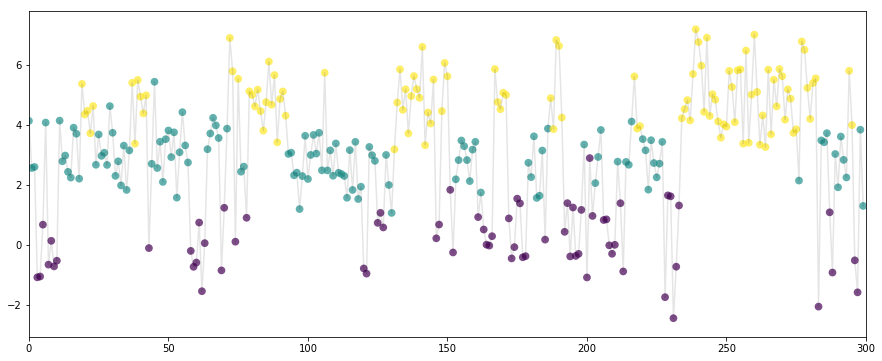

In [94]:
size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=np.array(X), lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.show()



Оцениваем параметры и значения скрытых состояний. А также нарисуем графики

In [95]:
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full",
                          n_iter=100, algorithm='viterbi')

# Оценка параметров 
remodel.fit(Y)  

# Оценка значений скрытых состояний
X_predicted = remodel.predict(Y)


Рисуем графики аналогично показанному ранее <br>
(Решение с перестановками, может быть, кривое, но зато простое и без циклов for)

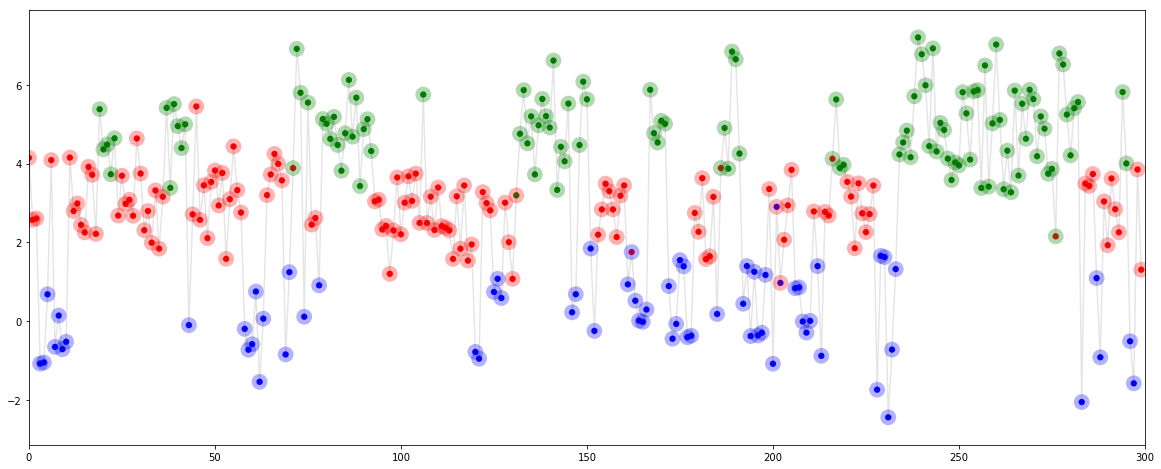

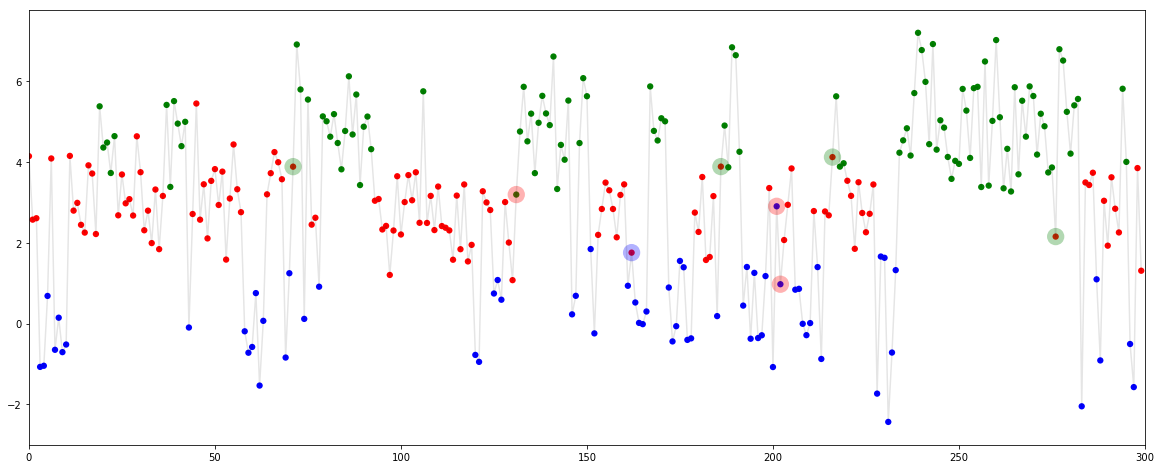

In [96]:
colors = np.array(['blue', 'red', 'green'])

# При необходимости меняем местами состояния
# Нужно рассмотреть различные перестановки (0, 1, 2) : (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)
# Если число i нужно поменять на j,то сначала поменяем его на j + 5, так как иначе могут произойти повторные замены
# (То есть, например, 1 поменяли на 2, а потом 2 поменяли на 0: в итоге и 1, и 2 поменяются на 0)
#(0, 1, 2) -> (0, 2, 1)
if (X != X_predicted).sum() > size / 2:
    X_predicted[X_predicted == 1] = 2 + 5
    X_predicted[X_predicted == 2] = 1 + 5
    X_predicted[X_predicted == 0] = 0 + 5
    X_predicted = X_predicted - 5
#(0, 2, 1)-> (1, 0, 2)
if (X != X_predicted).sum() > size / 2:
    X_predicted[X_predicted == 0] = 1 + 5
    X_predicted[X_predicted == 2] = 0 + 5
    X_predicted[X_predicted == 1] = 2 + 5
    X_predicted = X_predicted - 5
#(1, 0, 2)-> (1, 2, 0)
if (X != X_predicted).sum() > size / 2:
    X_predicted[X_predicted == 0] = 2 + 5
    X_predicted[X_predicted == 2] = 0 + 5
    X_predicted[X_predicted == 1] = 1 + 5
    X_predicted = X_predicted - 5
#(1, 2, 0) -> (2, 0, 1)
if (X != X_predicted).sum() > size / 2:
    X_predicted[X_predicted == 1] = 2 + 5
    X_predicted[X_predicted == 2] = 0 + 5
    X_predicted[X_predicted == 0] = 1 + 5
    X_predicted = X_predicted - 5
#(2, 0, 1) -> (2, 1, 0)
if (X != X_predicted).sum() > size / 2:
    X_predicted[X_predicted == 0] = 1 + 5
    X_predicted[X_predicted == 1] = 0 + 5
    X_predicted[X_predicted == 2] = 2 + 5 
    X_predicted = X_predicted - 5


plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], lw=0, s=40, alpha=1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X_predicted)], lw=0, s=250, alpha=0.3)
plt.xlim((0, size))
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted], Y[:, 0][X != X_predicted], 
            c=colors[np.array(X_predicted)[X != X_predicted]], lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()

In [97]:
print('Ошибка: ', round((X != X_predicted).sum() / size, 3), '%', sep='')

Ошибка: 0.027%


Как видим, в данном случае мы действительно очень хорошо предсказали значения скрытых состояний

Проверим, сошелся ли EM-алгоритм

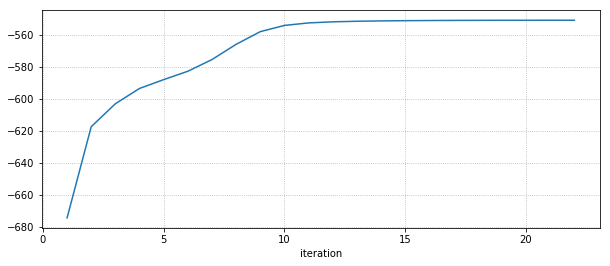

In [98]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл


remodel = hmm.GaussianHMM(n_components=3, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)


sys.stderr = saved_strerr

values = np.loadtxt('./est_values.txt')

plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.grid(ls=':')
plt.show()

Да, действительно сошелся. 

## 2.

Задаем скрытую марковскую цепь

In [99]:
model = hmm.GaussianHMM(n_components=2, covariance_type='full', 
                        algorithm='viterbi')

# Параметры марковской цепи - начальное состояние и матрица переходных вероятностей
model.startprob_ = np.array([0.7, 0.3])
model.transmat_ = np.array([[0.7, 0.3],
                            [0.15, 0.85]])

model.means_ = np.array([[0.0, 8.0], [3.0, 2.0]])
model.covars_ = np.array([[[1, 0.5],
                           [0.5, 3]],
                          [[1, 2],
                           [2, 0.1]]])

Генерируем последовательности X и Y

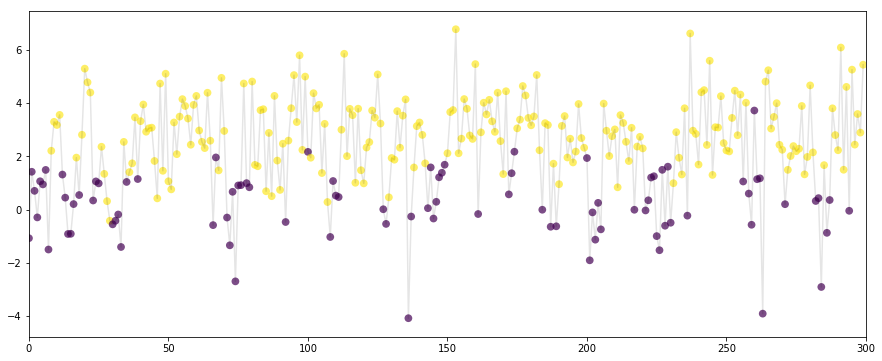

In [103]:
size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=np.array(X), lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.show()


In [104]:
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, algorithm='viterbi')

# Оценка параметров
remodel.fit(Y)  

# Оценка значений скрытых состояний
X_predicted = remodel.predict(Y)



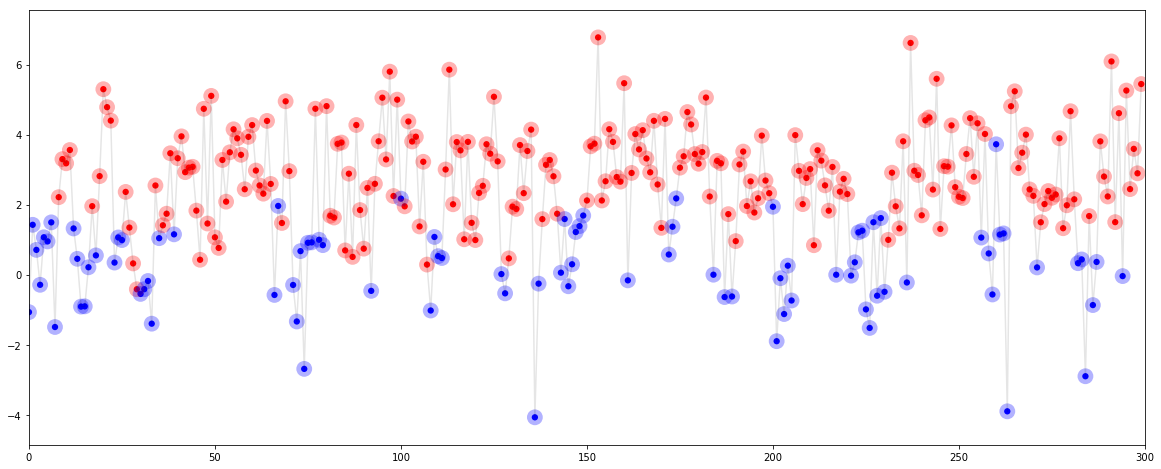

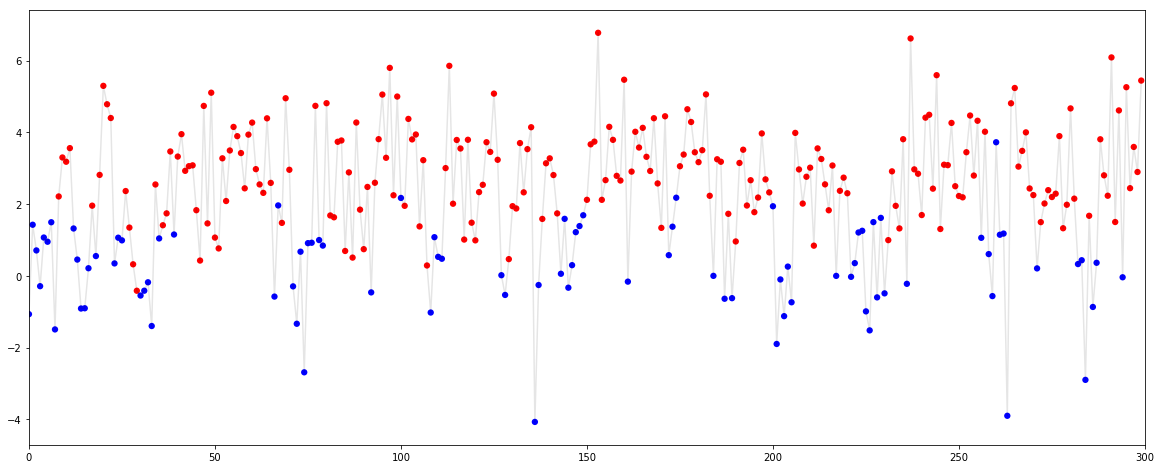

In [105]:
colors = np.array(['blue', 'red'])

# Состояния определяются с точностью до перестановки.
# При необходимости меняем местами состояния
if (X != X_predicted).sum() > size / 2:
    X_predicted = 1 - X_predicted

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X_predicted)], 
            lw=0, s=250, alpha=0.3)
plt.xlim((0, size))
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted], Y[:, 0][X != X_predicted], 
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()

Протестировав несколько раз для разных генераций последовательностей X и Y, получили один и тот же результат: ошибка составляет 0%

Теперь проверим, сошелся ли EM-алгоритм

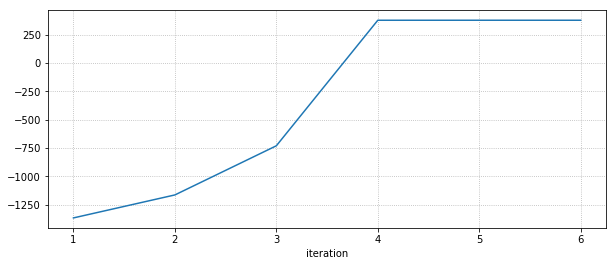

In [106]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)

sys.stderr = saved_strerr

values = np.loadtxt('./est_values.txt')

plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.grid(ls=':')
plt.show()

Действительно сошелся, причем уже после 4 итерации значение функционала совсем перестало изменяться. По полученным графикам можем сказать, что в двумерном гауссовском случае имеет место более быстрая сходимость, чем в одномерном. Так же в двумерном гауссовском случае были неплохо подобраны вектор средних и матрица ковариаций, что дало точность 100%.

Мы убедились, что оценка максимального правдоподобия, найденная при помощи EM-алгортма действительно имеет большую точность.

Кроме гауссовского случая в библиотеке реализовано два других

* `hmm.GMMHMM` --- распределение $Y_j$ при условии $X_j$ является смесью гауссовских распределений, 
* `hmm.MultinomialHMM` --- распределение $Y_j$ при условии $X_j$ является дискретным.

### 3. Part-of-speach tagging (8 баллов)

Теперь вам нужно самостоятельно реализовать метод распознавания частей речи для слов в предложении на основе скрытых марковских моделей. Метод реализовать можно с помощью библиотеки `hmmlearn`, но хранение разреженных матриц в в формате обычных матриц потребует большого количества памяти, поэтому на этот раз реализовать HMM придется самостоятельно. 

Будем считать, что каждый следующий тег непосредственно зависит только от двух предыдущих. Такая модель является марковской цепью, если в качестве состояний рассматривать все возможные пары тегов, причем матрица переходных вероятностей будет разреженной. Чтобы однозначно задать матрицу переходных вероятностей достаточно определить вероятности $\mathsf{P}(X_3=tag_3 \left| X_2=tag_2, X_1=tag_1\right)$, в качестве которых возьмем их оценку максимального правдоподобия (см. семинар). Сделайте так же оценку вероятностей $\mathsf{P}(Y_i=word \left| X_i=tag\right)$ для определения распределения слов для каждого тега.

Для удобства реализации можно считать, что перед началом предложения и после конца предложения находится несколько "пустых" тегов.

После того, как определена модель, нужно реализовать функцию, которая по заданному предложению для данной модели будет находить траекторию Витерби. Эта траектория и будет являться оценкой последовательности тегов для данного предложения. Посчитайте точность определения тегов на тестовом наборе данных.

**Данные** возьмите такие же, как в примере с семинара.

Сравните точность вашей модели с простой моделью, которая была показана на семинаре, а так же со следующими встроенными моделям:

In [4]:
import nltk

Скачиваем `conll2000` 

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [5]:
from nltk.corpus import conll2000

Разбиваем данные на 2 части

In [145]:
train_sents = conll2000.tagged_sents()[:8000]
test_sents = conll2000.tagged_sents()[8000:]

Состояния марковской цепи - все различные пары тегов. <br>
**Определим скрытую марковскую цепь.** <br>
Пусть $Z_k = (X_k, X_{k -1})$ - скрытые состояния <br>
$Y_k$ - k-ое слово в предложении. <br>
Тогда $$P(X_k=tag_k| X_{k-1}=tag_{k-1}, X_{k-2}=tag_{k-2}) = $$ $$P(X_k=tag_k, X_{k-1}=tag_{k-1}| X_{k-1}=tag_{k-1}, X_{k-2}=tag_{k-2})=$$ $$P(Z_k = (tag_k, tag_{k-1})| Z_{k-1} = (tag_{k-1}, tag_{k-2}))$$ 
<br>
**Оценка максимального правдоподобия для матрицы переходных вероятностей :** <br>
Оценка с семинара: $$p_{i, j}^{*} = \frac{n_{i,j}}{n_i}$$
где $$n_{i,j} = \sum_{k=1}^{n}I(Z_{k-1} = i, Z_{k} = j), n_i = \sum_{j} n_{i, j}$$ 
То есть, $n_{i,j}$ - общее кол-во переходов из состояния i в состояние j  <br>
$n_i$ - общее кол-во переходов из состояния i в какое-либо другое <br>
(состояния i и j - это некоторая пара тегов)<br>

**Оценка для условных вероятностей:** <br>
$$P(Y_k = {word}_k| X_k = tag_k) = P(Y_k = {word}_k| X_k = tag_k, X_{k-1} = tag_{k-1}) =$$ $$P(Y_k = {word}_k| Z_k = (tag_k, tag_{k-1})) = $$ $$ \frac{P(Y_k = {word}_k, Z_k = (tag_k, tag_{k-1}))}{P(Z_k = (tag_k, tag_{k-1}))}$$
<br> так как $Y_k$ не зависит от $X_{k-1}$ при условии выполнения $X_{k}$
<br>
<br>

**Создание состояний**

In [242]:
#сначала найдем всевозможные теги
tags = set()
for line in train_sents:
    for word in line:
        tags.add(word[1])

#добавим граничный тег
tags.add('Border')
print(tags)

{':', 'RBR', 'VBZ', "''", 'JJ', '(', ')', 'MD', 'SYM', 'DT', 'NNS', 'PRP', '#', 'EX', 'VBN', 'RB', 'PRP$', 'VB', 'NN', '.', 'POS', 'JJS', 'JJR', 'Border', 'NNP', 'CC', 'VBP', 'WRB', 'PDT', '$', 'VBD', 'RBS', 'UH', ',', 'WDT', 'WP', 'IN', 'VBG', 'RP', 'WP$', '``', 'CD', 'FW', 'TO', 'NNPS'}


In [243]:
#сделаем всевозможные состояния, состоящие из пары тегов
states = np.vstack(np.array([[(i, j) for i in tags] for j in tags]))

#словарь с индексами состояний
indexes_states = {tuple(states[i]):i for i in range(len(states))}

print("Получили " + str(len(states)) + ' состояний')
print("Размер списка states :", states.shape)

Получили 2025 состояний
Размер списка states : (2025, 2)


Также создадим инверсированный словарь - индекс:состояние (потом понадобится)

In [344]:
states_indexes = dict()
for key in indexes_states.keys():
    states_indexes[indexes_states[key]] = key


**Оценка матрицы переходных вероятностей**

Посчитаем матрицу, в которой ij-ый элемент - общее кол-во переходов из состояния i в состояние j. (Нужно для оценки $p_{i, j}$)<br>
К каждому предложению в начале и в конце добавим граничное слово вида ('_', 'Border')


In [245]:
#матрица, в которой ij-ый элемент - общее кол-во переходов из состояния i в состояние j
n_i_j = np.zeros((len(states), len(states)))

for line in train_sents:
    #добавляем граничное слово
    line = [('_', 'Border')] + line + [('_', 'Border')]
    for i in range(1, len(line) - 1):
        cur_state = indexes_states[(line[i-1][1], line[i][1])]
        next_state = indexes_states[(line[i][1], line[i+1][1])]
        n_i_j[cur_state][next_state] += 1.

n_i = np.sum(n_i_j, axis = 1)


Находим матрицу переходных вероятностей

In [246]:
#np.tile делает из строки матрицу, составленную из таких строк
prob_matrix = np.nan_to_num(n_i_j / np.tile(n_i, (len(states), 1)).T)

 Однако в получившейся матрице переходных вероятностей есть строки, состоящие только из нулей. Это связано с тем, что не все состояния, то есть пары тегов, встречаются в train_sents. Будем предполагать, что из таких состояний мы равновероятно переходим во все остальные. Это не сильно что-то испортит, так как судя по всему, такие состояния встречаются крайне редко. Так что изменим немного получившуюся матрицу.
 

In [247]:
for i in range(len(states)):
    if prob_matrix[i].sum() == 0:
        prob_matrix[i] = [1 / len(states)] * len(states)


Так как состояний слишком много переходные вероятности получатся слишком маленькими. Так что будем рассматривать логарифмическую матрицу переходных вероятностей. 

In [248]:
log_prob_matrix = np.log(prob_matrix)
#убираем бесконечности
log_prob_matrix[log_prob_matrix == -np.inf] = -1e7

**Оценка условных вероятностей** <br>
Для нахожения условных вероятностей будем предполагать, что $P(Y_k = {word}_k | X_k = {tag}_k)$ не зависит от k. <br>
То есть будем рассматривать не каждую k-ую позицию в каждом предложении, а сразу все позиции.

In [250]:
#для начала пронумеруем имеющиеся слова
indexes_words = dict()
ind = 0
for line in train_sents:
    for word in line:
        if word[0] not in indexes_words.keys():
            indexes_words[word[0]] = ind
            ind += 1
            

Теперь построим матрицу для $N(Y_k = {word}_k, Z_k = (tag_k, tag_{k-1}))$ , где N обозначает кол-во <br>
А также построим вектор $N(Z_k = (tag_k, tag_{k-1}))$

In [251]:
counts_y_z = np.zeros((len(indexes_words), len(indexes_states)))

counts_z = np.zeros(len(indexes_states))

for line in train_sents:
    #опять добавляем граничное слово
    line = [('_', 'Border')] + line + [('_', 'Border')]
    for i in range(1, len(line) - 1):
        cur_state = indexes_states[(line[i-1][1], line[i][1])]
        cur_word = indexes_words[line[i][0]]
        counts_y_z[cur_word][cur_state] += 1
        counts_z[cur_state] += 1
        
        

$$P(Y_k = {word}_k| Z_k = (tag_k, tag_{k-1})) = \frac{P(Y_k = {word}_k, Z_k = (tag_k, tag_{k-1}))}{P(Z_k = (tag_k, tag_{k-1}))} = \frac {N(Y_k = {word}_k, Z_k = (tag_k, tag_{k-1}))}{\sum_{word, tag_1, tag_2} N(Y_k = word, Z_k = (tag_1, tag_2))} \frac{\sum_{tag_1, tag_2} N(Z_k = (tag_1, tag_2))}{N(Z_k = (tag_k, tag_{k-1}))}$$ <br>
В данном случае $ \sum_{word, tag_1, tag_2} N(Y_k = word, Z_k = (tag_1, tag_2)) = \sum_{tag_1, tag_2} N(Z_k = (tag_1, tag_2)) = $ кол-ву слов (с повторениями) в предложениях <br> <br>
$$\Rightarrow P(Y_k = {word}_k| Z_k = (tag_k, tag_{k-1})) = \frac{N(Y_k = {word}_k, Z_k = (tag_k, tag_{k-1}))}{N(Z_k = (tag_k, tag_{k-1}))}$$

In [315]:
#матрица условных вероятностей
P_y_z = np.nan_to_num(counts_y_z / np.tile(counts_z, (len(indexes_words), 1)))

Также будем рассматривать логарифмическую матрицу условных вероятностей

In [316]:
log_P_y_z = np.log(P_y_z)
log_P_y_z[log_P_y_z == -np.inf] = -1e9

**Оценим начальное распределение** <br>
Для этого для каждого тега найдем вероятность состояния ('Border', 'tag') <br>
Тоже рассматриваем логарифмическое начальное распределение

In [254]:
counts_with_border = np.zeros(len(states))
for line in train_sents:
    first_state = indexes_states[('Border', line[0][1])]
    counts_with_border[first_state] += 1
    
start_distribution = np.log(counts_with_border / np.sum(counts_with_border))

Все посчитали. Теперь можем перейти к реалицазии поиска траектории Витерби. <br>
**Траектория Витерби** <br>
$z^* = \arg \max_{z}P(Z = z|Y = y) = \arg \max_{z} \log P(Z = z, Y = y)$ <br>

*Алгоритм:* <br>
Заведем 2 матрицы: prob_of_best_way и stats_of_best_way. <br>
prob_of_best_way: ij-ый элемент-вероятность наиболее вероятного пути,оканчивающегося в состоянии i на j-ом шаге <br>
stats_of_best_way: ij-ый элемент - состояние, из которого нужно перейти в состояние i на j-ом шаге, чтоб получить prob_of_best_way_i_j <br>
<br>
*Решаем задачу динамическим программированием:* для этого на каждом шаге для каждого состояния рассматриваем вероятности наиболее вероятных путей в остальные состояния и домножая на вероятность перехода с этого состояния в выбранное и на условную вероятность получаем наиболее вероятный путь до выбранного состояния. То есть максимизируем величину $P(Z_1 = z_1, ..., Z_k = i| Y = y)$ для каждого состояния i на момент k-ого времени. <br>

*Что делать, если у нас появилось новое слово? *<br>
Чтобы не пропустить наиболее вероятный тег, будем предполагать что наше слово может иметь любой тег(какой-то, но мы его не знаем). Поэтому рассматривая состояние i будем предполагать, что $P(X_k = i| Y_k = UnknownWord) = 1$ <br>
То есть при подсчете элементов матрицы prob_of_best_way в таком случае полагать условную вероятность равную 1. <br>
<br>

(Работаем не с обычными матрицей переходных вероятностей, матрицей условных распределений и вектором начального распределения, а с логарфмическими. Поэтому вместо умножения будем складывать)

In [343]:
def viterbi(Y) :

    #матрица,в которой ij-ый элемент-вероятность наиболее вероятного пути,оканчивающегося в состоянии i на j-ом шаге
    prob_of_best_way = np.zeros((len(indexes_states), len(Y)))

    #матрица, в которой ij-ый элемент - состояние, из которого нужно перейти в состояние i на j-ом шаге,
    #чтобы получить наиболее вероятный путь, оканчивающийся в состоянии i
    stats_of_best_way = np.zeros((len(indexes_states), len(Y)))
    
    #заполняем начальными значениями
    if Y[0] < len(indexes_words) :
        prob_of_best_way[:,0] = start_distribution + log_P_y_z[Y[0]]
    else:
        prob_of_best_way[:,0] = start_distribution
    X_predicted = np.array(np.zeros(len(Y)), dtype = int)
    
    #динамически заполяем матрицы
    for step in range(1, len(Y)):
        for state in range(len(indexes_states)):
            
            if Y[step] < len(indexes_words) :
                prob_of_best_way[state][step] = log_P_y_z[Y[step]][state] + 
                        np.max( prob_of_best_way[:,step - 1] + log_prob_matrix[:,state])
                    
                stats_of_best_way[state][step] = np.argmax( prob_of_best_way[:,step - 1] + log_prob_matrix[:,state])
                
            else:
                prob_of_best_way[state][step] = np.max( prob_of_best_way[:,step - 1] + log_prob_matrix[:,state])
                stats_of_best_way[state][step] = np.argmax( prob_of_best_way[:,step - 1] + log_prob_matrix[:,state])
                

    #на последнем шаге выбираем состояние, в который ведет наиболее вероятный путь
    X_predicted[-1] = np.argmax(prob_of_best_way[:, len(Y) - 1])
    #запоняем предыдущие состояния по полученной матрице stats_of_best_way
    for i in range(len(Y) - 2, -1, -1):
        X_predicted[i] = stats_of_best_way[X_predicted[i + 1]][i + 1]
        
    return X_predicted
    


**Проверка**

Теперь работаем с test_sents. <br>
Для начала нужно понять какие слова у нас есть и пронумеровать их.

In [197]:
#двумерный массив, в котором i-ая строка отвечают словам в i-ом предложении
Y = []

new_index = len(indexes_words)
for line in test_sents:
    words_in_line= []
    for word in line:
        if word[0] in indexes_words.keys():
            words_in_line.append(indexes_words[word[0]])
        else:
            words_in_line.append(new_index)
            new_index += 1
    Y.append(words_in_line)


Теперь поймем какие теги у этих слов.

In [333]:
#двумерный массив, в котором i-ая строка отвечают тегам в i-ом предложении
test_tags = []

for line in test_sents:
    tags_in_line= []
    for word in line:
        tags_in_line.append(word[1])
    test_tags.append(tags_in_line)


Но функция viterbi возвращает предсказание состояний вида $i$, то есть номера состояний. Переведем это в последовательность тегов.

In [275]:
def index_to_tags(index_ar):
    to_stats = np.array([states_indexes[index_ar[i]] for i in range(len(index_ar))])
    to_tags = to_stats[:,1]
    return to_tags
    

Теперь можем запустить алгоритм Витерби

In [350]:
predicted_tags = []
for i in range(len(test_sents)):
    predicted_tags.append(index_to_tags(viterbi(Y[i])))

In [320]:
print('%.3f' % accuracy_score(np.concatenate(np.array(test_tags), axis=0), 
                              np.concatenate(np.array(predicted_tags), axis=0)))

0.944


**Сравним**

Точность модели с семинара: 0.907 

unigram_tagger = nltk.UnigramTagger(train_sents)
bigram_tagger = nltk.BigramTagger(train_sents)
combined_bigram_tagger = nltk.BigramTagger(train_sents, backoff=unigram_tagger)

In [347]:
print("Точность UnigramTagger ", unigram_tagger.evaluate(test_sents))

Точность UnigramTagger  0.895637013342555


In [348]:
print("Точность BigramTagger ", bigram_tagger.evaluate(test_sents))

Точность BigramTagger  0.20938877842137113


In [349]:
print("Точность combined BigramTagger", combined_bigram_tagger.evaluate(test_sents))

Точность combined BigramTagger 0.906919108959396


Как видим точность полученной модели больше. Из этого, что для определения части речи (состояния) слова не достаточно рассматривать лишь предыдущее слово. (А именно, можно сделать предположение, что точность моделей, в которых рассматривается несколько предыдущих слов будет заметно больше) <br>
Также поняли что траектория Витерби дает действительно хорошую оценку скрытых состояний. <br>
К тому же научились интерпретировать некоторые современные вопросы (такие как Part-of-speach tagging) в качестве скрытых марковских моделей и пришли к выводу, что такая интерпретация иногда дает очень хорошую точность. (Спасибо, было приятно)